In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta
from scipy.ndimage import binary_dilation

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import espra, smooth, robust_smooth, tangential_velocity, fit_psi_params, psi_params


### Satellite Data

In [3]:
import copernicusmarine

copernicusmarine.subset(
  dataset_id="cmems_mod_glo_phy-cur_anfc_0.083deg_PT6H-i",
  variables=["uo", "vo"],
  minimum_longitude=149,
  maximum_longitude=158,
  minimum_latitude=-42,
  maximum_latitude=-34,
  start_datetime="2023-10-18T06:00:00",
  end_datetime="2024-02-11T18:00:00",
  minimum_depth=0.49402499198913574,
  maximum_depth=0.49402499198913574,
)



ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_copernicus_CCE_2023_6hr.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['longitude'][:].data, ssh_dataset['latitude'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh, indexing='ij')
u_ssh, v_ssh = np.squeeze(ssh_dataset['uo'][:].data), np.squeeze(ssh_dataset['vo'][:].data) 
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['time'][:].data # Hours Since 1950-01-01

ref_date = pd.Timestamp("1950-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="h")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
    ut = np.where(np.abs(ut) < 100, ut, np.nan)
    vt = np.where(np.abs(vt) < 100, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


(np.float64(-464218.16710824956),
 np.float64(324076.83364160644),
 np.float64(-455100.0000000002),
 np.float64(432899.9999999998))

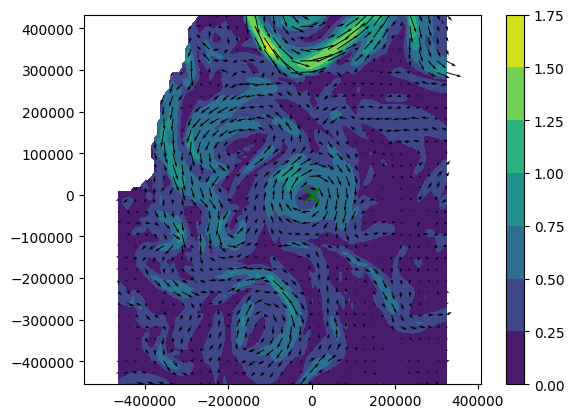

In [4]:
t_idx = 0
dic = dic_ssh_data[list(dic_ssh_data.keys())[t_idx]]
ut, vt = dic['u'], dic['v']
plt.contourf(x_ssh, y_ssh, np.hypot(ut, vt))
plt.colorbar()
spac = 3
plt.quiver(x_ssh[::spac, ::spac], y_ssh[::spac, ::spac],
           ut[::spac, ::spac], vt[::spac, ::spac])
plt.scatter(0,0, marker='x', color='r', s=100)
plt.axis('equal')


xc             yc         w  \
0     -8889.976330   -4256.986103 -0.000029   
1     -4698.739050   -4114.006644 -0.000030   
2     -8152.464261   -1965.855501 -0.000030   
3     -7279.129178   -9218.100343 -0.000030   
4     -4685.717073    -484.474034 -0.000028   
..             ...            ...       ...   
255 -133220.435252  110550.579627 -0.000029   
256 -119522.155987  130745.215727 -0.000027   
257 -170284.177903   66878.301452 -0.000024   
258 -135372.663749  106451.140746 -0.000023   
259 -115543.583771  128489.280666 -0.000027   

                                                     Q             Rc  \
0    [[1.0242373036542909, -0.09542101991089416], [...   86950.397808   
1    [[1.0680272993760624, -0.12809136281106048], [...   84958.630633   
2    [[1.0837587585112434, -0.06861732002365956], [...   85218.492452   
3    [[1.0089063372502542, -0.09125309048248038], [...   89310.377969   
4    [[1.0848451119938265, -0.13601125282480062], [...   81967.505845   
..                                                 ...            ...   
255  [[1.6892672840214467, -1.0936877835010999], [-...  120376.947490   
256  [[2.516061690955229, -1.9155967259627291], [-1...  145779.797925   
257  [[2.7258403567423577, -2.028534412953861], [-2...  130887.500359   
258  [[1.596527905285453, -0.7605457042064072], [-0...  127092.144066   
259  [[2.102783043663754, -1.8240197404025482], [-1...  143598.692395   

             psi0         A                Time  
0    64311.156966 -0.000009 2023-10-18 12:00:00  
1    63381.322501 -0.000009 2023-10-18 18:00:00  
2    64581.771506 -0.000009 2023-10-19 00:00:00  
3    64985.227679 -0.000008 2023-10-19 06:00:00  
4    61547.515771 -0.000009 2023-10-19 12:00:00  
..            ...       ...                 ...  
255  71012.038062 -0.000005 2023-12-21 06:00:00  
256  65383.802092 -0.000003 2023-12-21 11:56:15  
257  65918.416129 -0.000004 2023-12-21 18:00:00  
258  95521.057786 -0.000006 2023-12-22 00:00:00  
259  67500.443018 -0.000003 2023-12-22 06:00:00  

[260 rows x 8 columns]

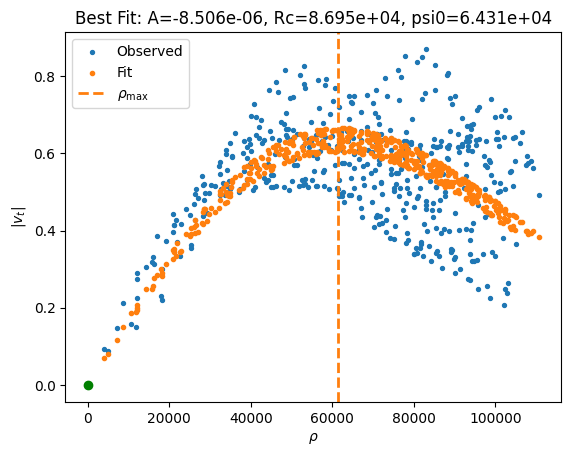

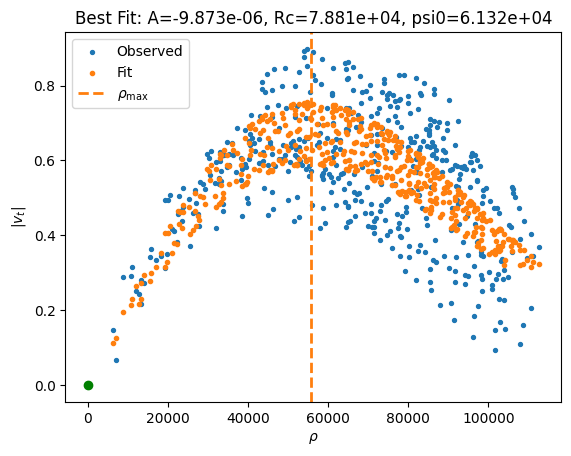

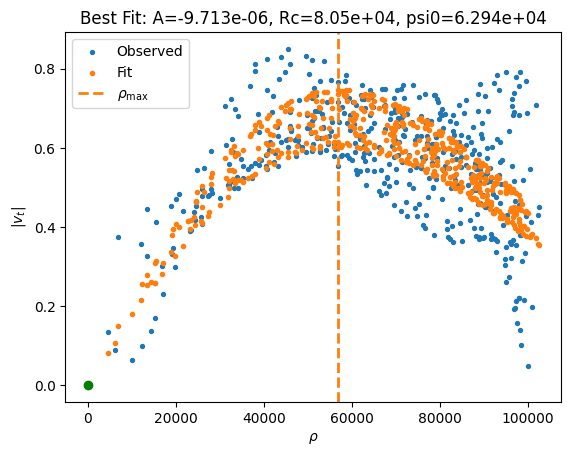

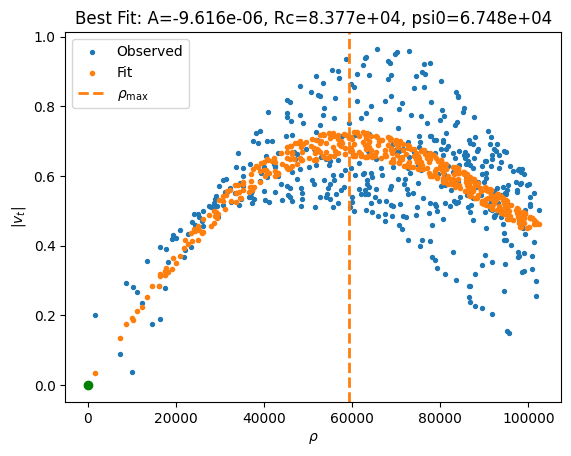

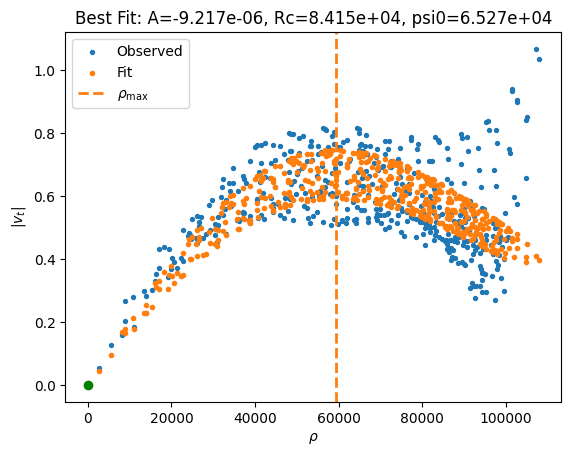

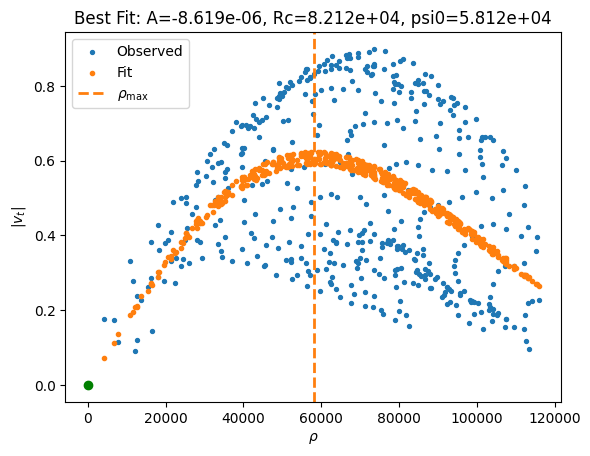

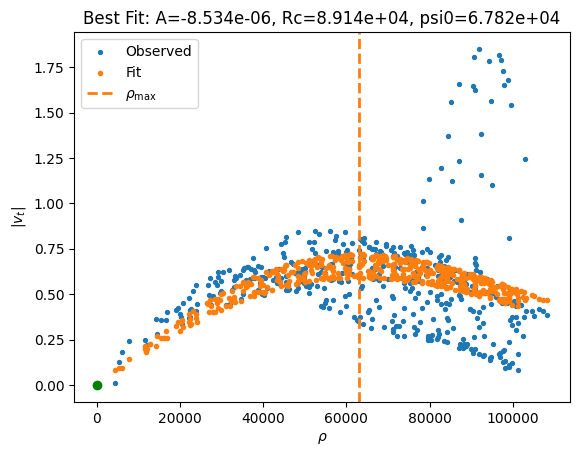

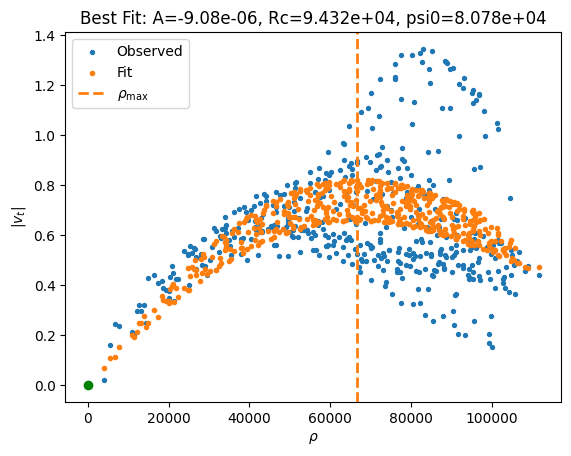

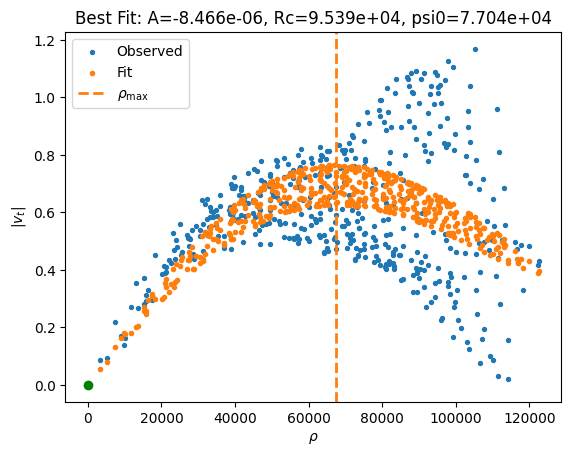

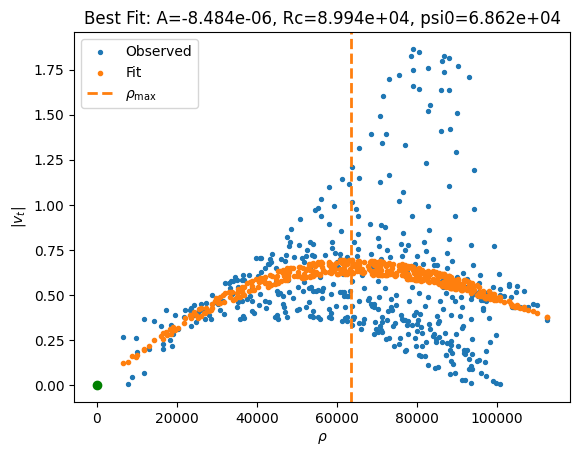

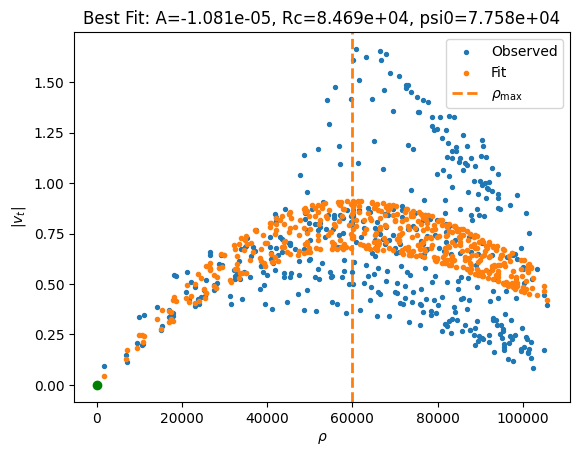

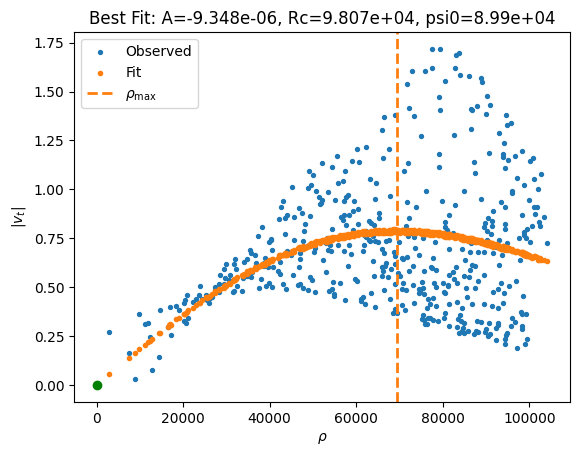

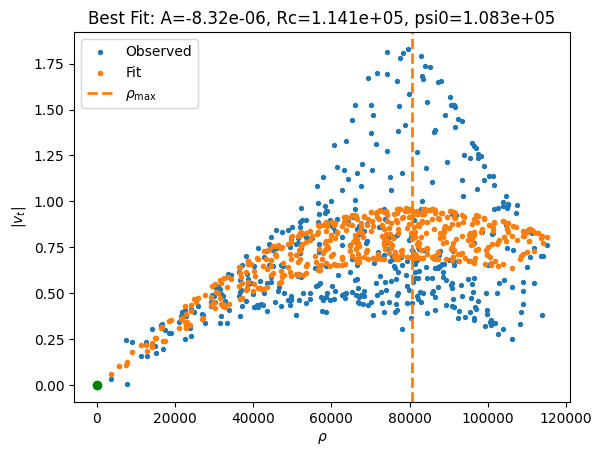

In [5]:
xc_pre, yc_pre = 0, 0
q11_pre, q12_pre, q22_pre = 1, 0, 1
df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Time'])
rho_core_thresh = 50000
rho_outer_core_thresh = 100000
dic_params = {}
for k, t_idx in enumerate(range(len(dic_ssh_data))):
    time = list(dic_ssh_data.keys())[t_idx]
    dic = dic_ssh_data[time]
    ut, vt = dic['u'], dic['v']

    dx, dy = x_ssh - xc_pre, y_ssh - yc_pre
    rho_search = np.sqrt(q11_pre*dx**2 + 2*q12_pre*dx*dy + q22_pre*dy**2)
    mask_core = rho_search < rho_core_thresh
    xi, yi, ui, vi = x_ssh[mask_core], y_ssh[mask_core], ut[mask_core], vt[mask_core]
    xc, yc, w, Q, _, _, A0 = espra(xi, yi, ui, vi, Rc_max=150000)
    # All
    mask_outer = rho_search < rho_outer_core_thresh
    axi, ayi, aui, avi = x_ssh[mask_outer], y_ssh[mask_outer], ut[mask_outer], vt[mask_outer]

    if (np.hypot(xc-xc_pre, yc-yc_pre)<100000) & (np.sign(w)<0):

        df = psi_params(xc, yc, Q, axi, ayi, aui, avi)
        df = df[df.vt < 0]
        Rc, psi0, A = fit_psi_params(df.rho2, df.Qr, df.vt, A0=A0, Rc_max=150000, plot=True if k%20==0 else False)     
        
        if A >= 0:
            Rc, psi0, A = np.nan, np.nan, np.nan
        df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q,
                                   'Rc': Rc, 'psi0': psi0, 'A': A, 'Time': time}
        xc_pre, yc_pre = xc, yc
        q11_pre, q12_pre, q22_pre = Q[0,0], Q[1,0], Q[1,1]
        # Gather data for better psi param fit
        dic_params[time] = psi_params(xc, yc, Q, axi, ayi, aui, avi)
    else:
        break
df_res


In [6]:
def combine_with_adjacent(dfs: dict, order=None, k=1, how='outer', include_self=True, ignore_index=True, dedup=False):
    """
    Build a new dict with the same keys where each value is the concat of its
    own DataFrame and its k adjacent neighbours in `order`.

    Parameters
    ----------
    dfs : dict[key -> pd.DataFrame]
        Original mapping.
    order : list | None
        Sequence defining adjacency. If None, uses dict insertion order.
        If None and keys are sortable, falls back to sorted(dfs).
    k : int
        Number of neighbours on each side to include (window radius).
    how : {'outer','inner'}
        Join type used by pd.concat to align columns.
    include_self : bool
        If False, excludes the key’s own DataFrame (rare, but supported).
    ignore_index : bool
        Passed to pd.concat.
    dedup : bool
        If True, drop duplicate rows after concat.

    Returns
    -------
    dict[key -> pd.DataFrame]
    """
    if order is None:
        # Try insertion order; if keys not ordered, fall back to sorted if possible
        try:
            order = list(dfs.keys())
        except Exception:
            order = None
    if order is None:
        try:
            order = sorted(dfs.keys())
        except Exception:
            raise ValueError("Provide `order` to define adjacency.")

    idx_map = {k_: i for i, k_ in enumerate(order)}
    out = {}

    for key in order:
        i = idx_map[key]
        left = max(0, i - k)
        right = min(len(order), i + k + 1)
        window_keys = order[left:right]
        if not include_self:
            window_keys = [wk for wk in window_keys if wk != key]

        frames = [dfs[wk] for wk in window_keys]
        combined = pd.concat(frames, axis=0, join=how, ignore_index=ignore_index, sort=False)
        if dedup:
            combined = combined.drop_duplicates()
        out[key] = combined

    return out

new_dfs = combine_with_adjacent(dic_params, k=5)


/home/z5297792/UNSW-MRes/MRes/modules/utils.py:445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


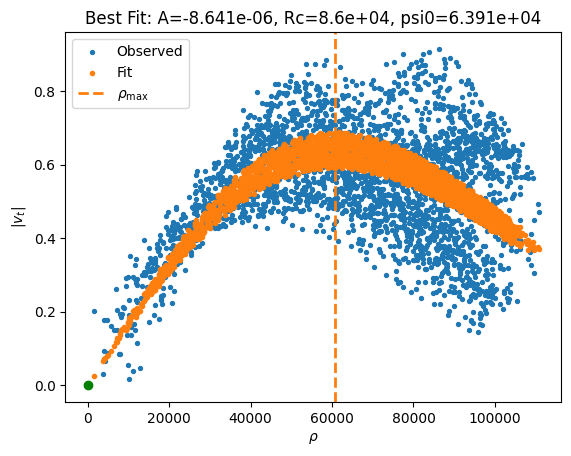

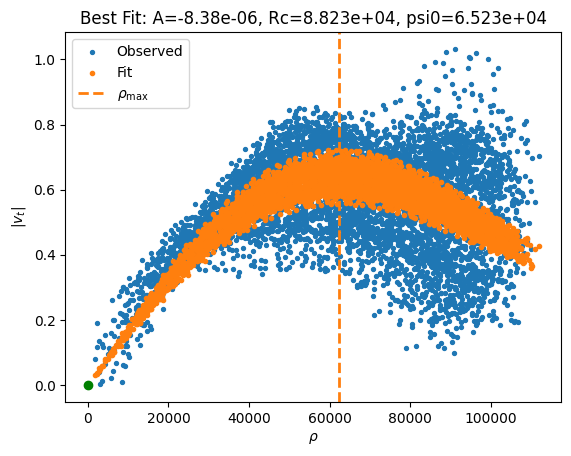

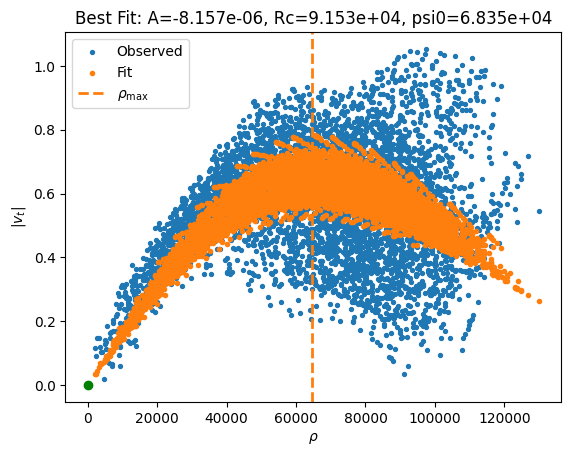

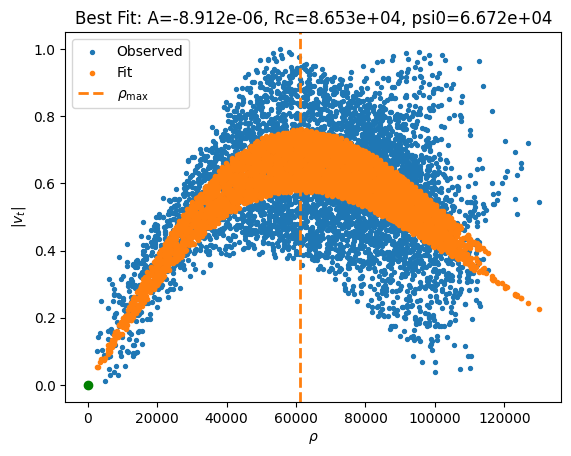

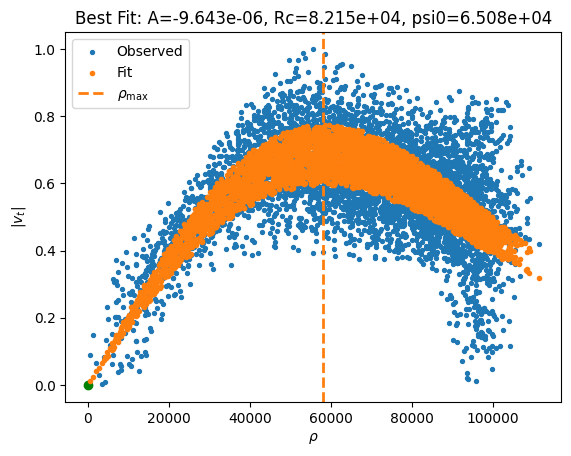

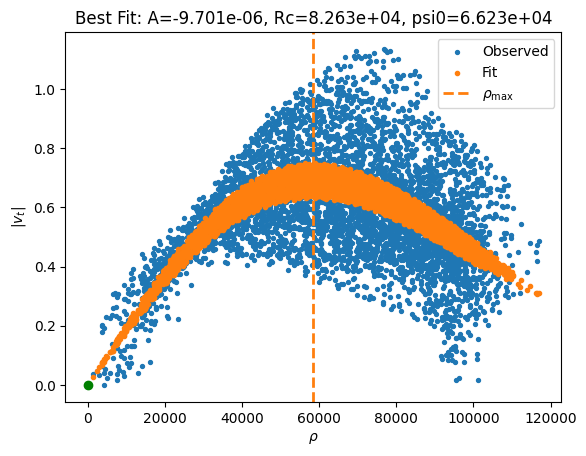

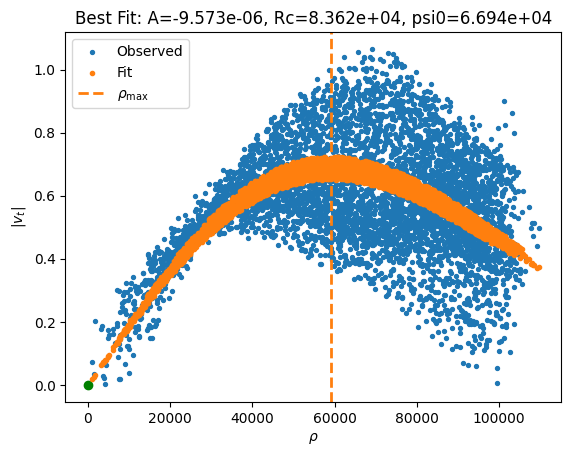

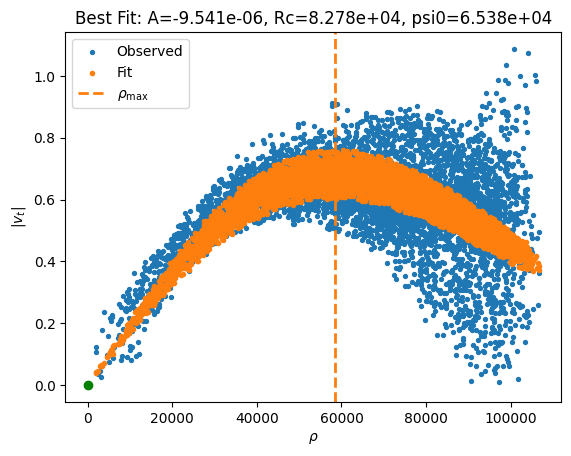

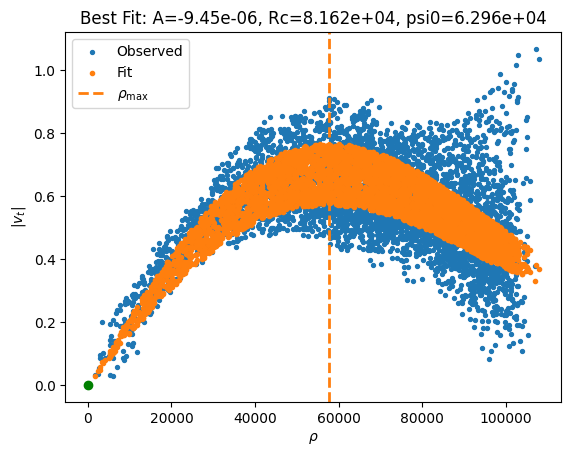

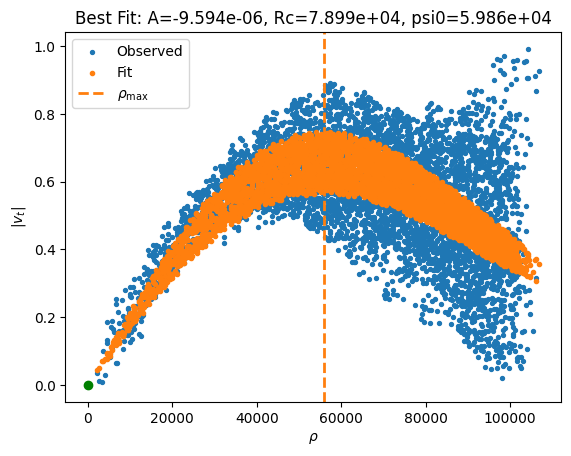

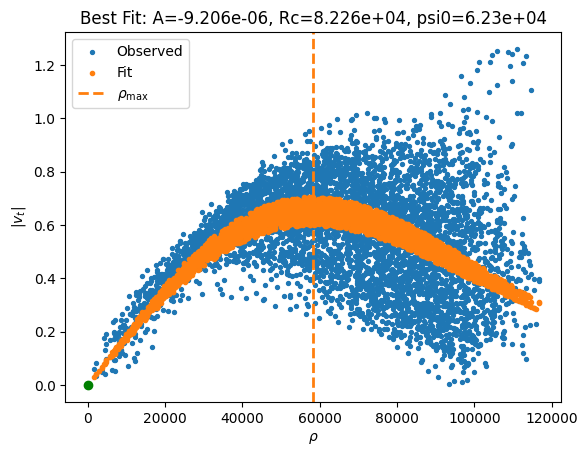

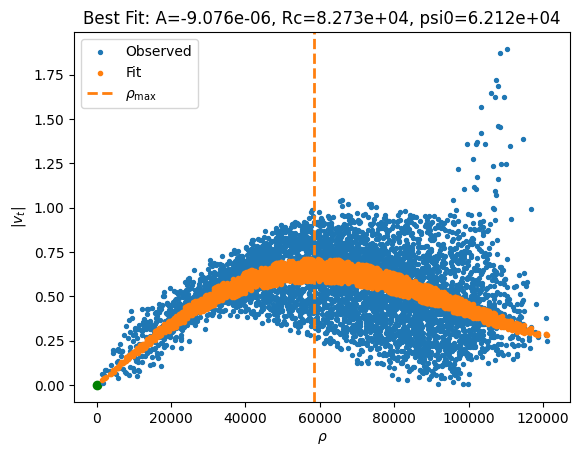

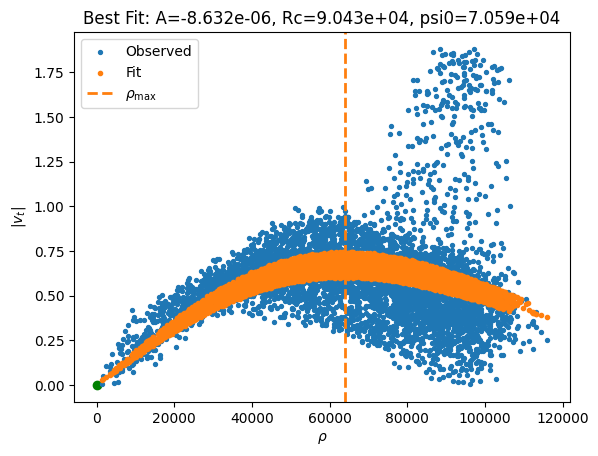

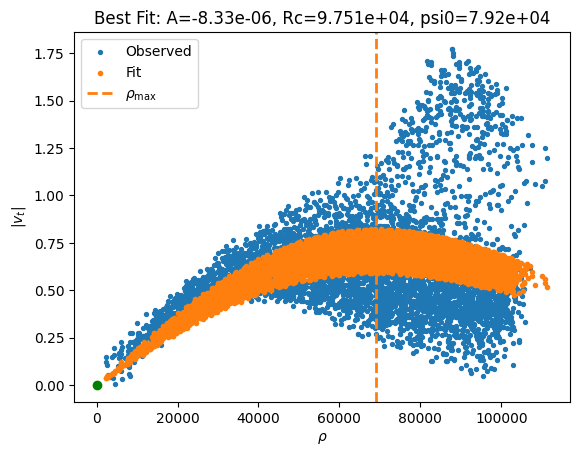

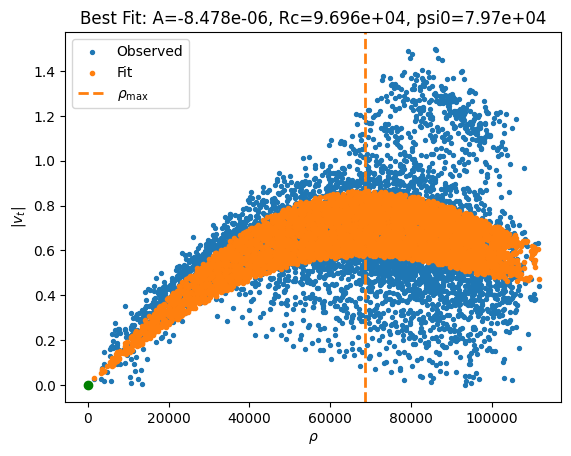

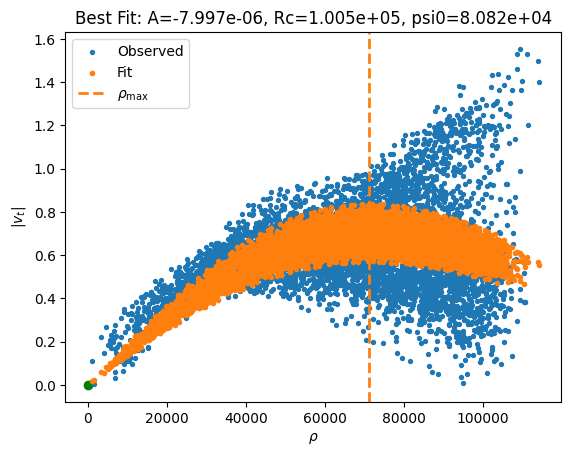

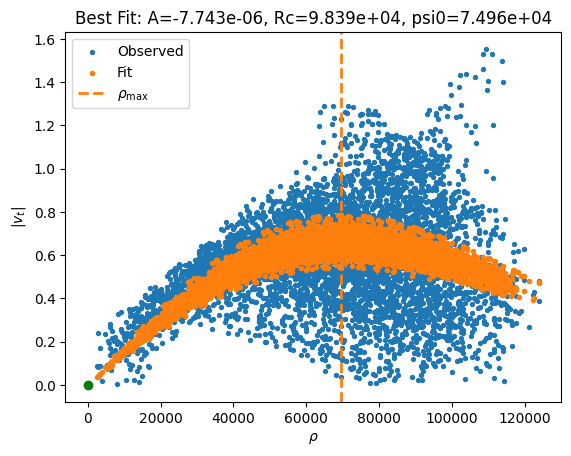

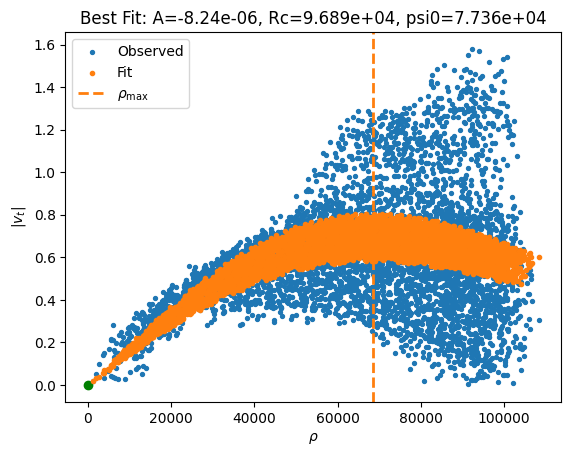

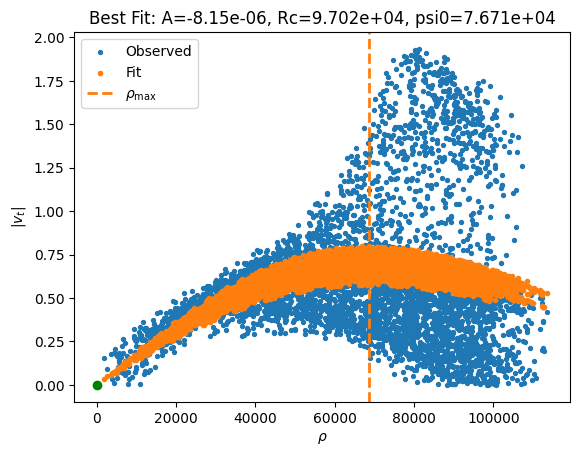

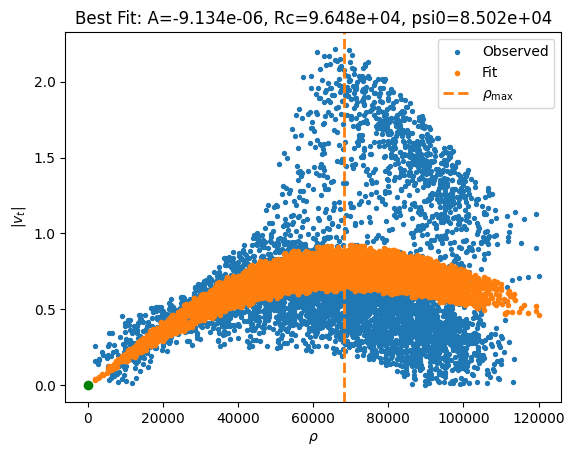

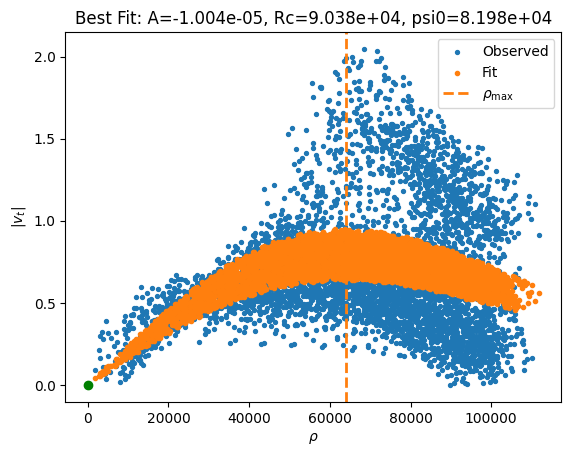

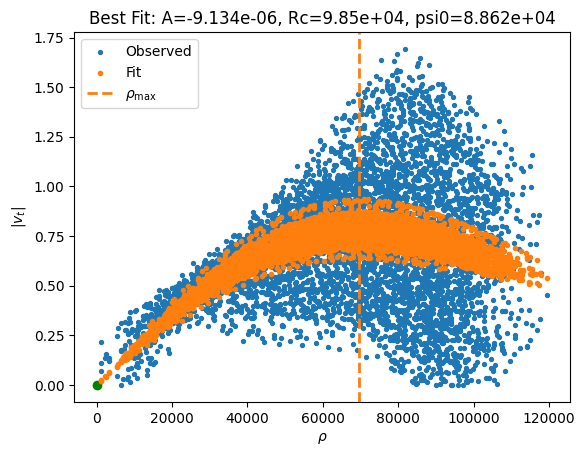

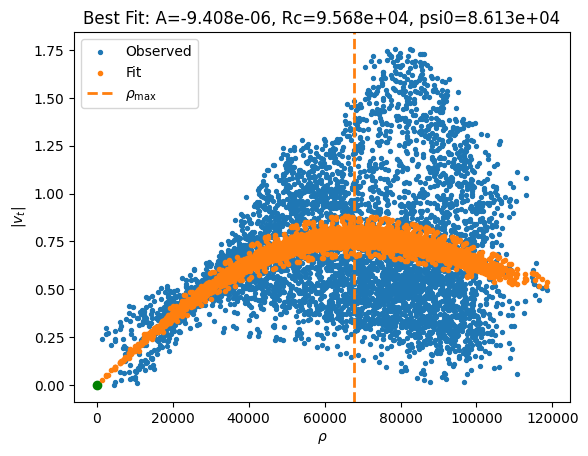

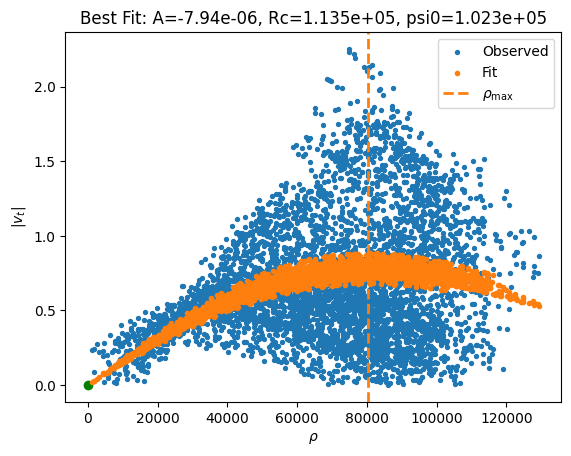

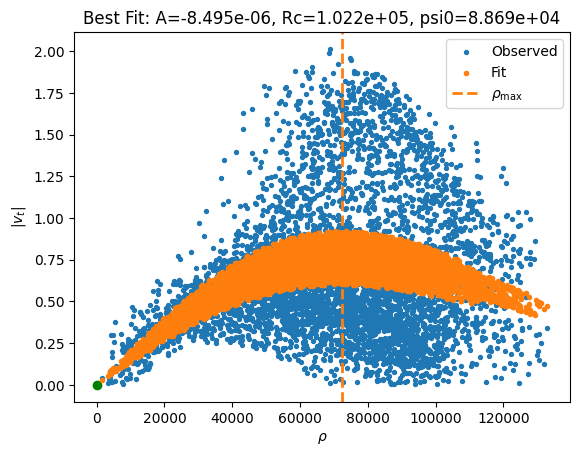

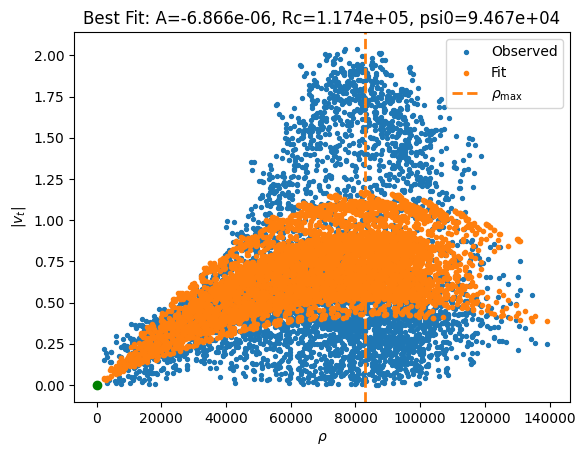

In [7]:
Rcs, psi0s, As = [], [], []
for k, time in enumerate(new_dfs.keys()):
    df = new_dfs[time].copy()
    df = df[df.vt <= 0]
    Rc_opt, psi0_opt, A_opt = fit_psi_params(df.rho2, df.Qr, df.vt, plot=True if k%10==0 else False, Rc_max=1e6) 
    Rcs.append(Rc_opt); psi0s.append(psi0_opt); As.append(A_opt)
df_res['Rc_opt'] = Rcs; df_res['psi0_opt'] = psi0s; df_res['A_opt'] = As


(np.float64(-179202.9038932041),
 np.float64(17009.067901796363),
 np.float64(-20267.16502565152),
 np.float64(137936.28147738977))

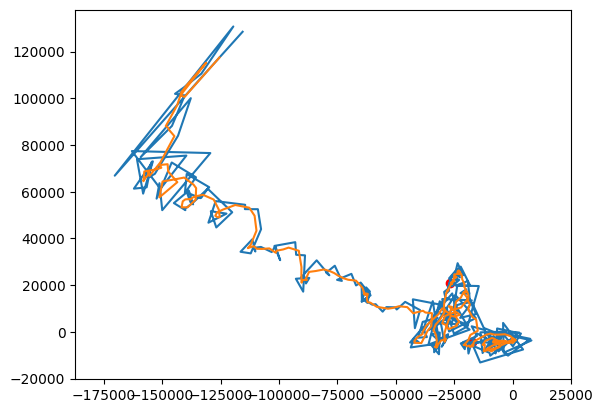

In [8]:
wdw = 3
df_res['sxc'] = smooth(df_res.xc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Time, window=wdw, num=len(df_res)) 

plt.plot(df_res.xc, df_res.yc)
plt.plot(df_res.sxc, df_res.syc)

for k in [44, 86]:
    data = df_res.iloc[k]
    plt.scatter(data.xc, data.yc, color='r')
plt.axis('equal')


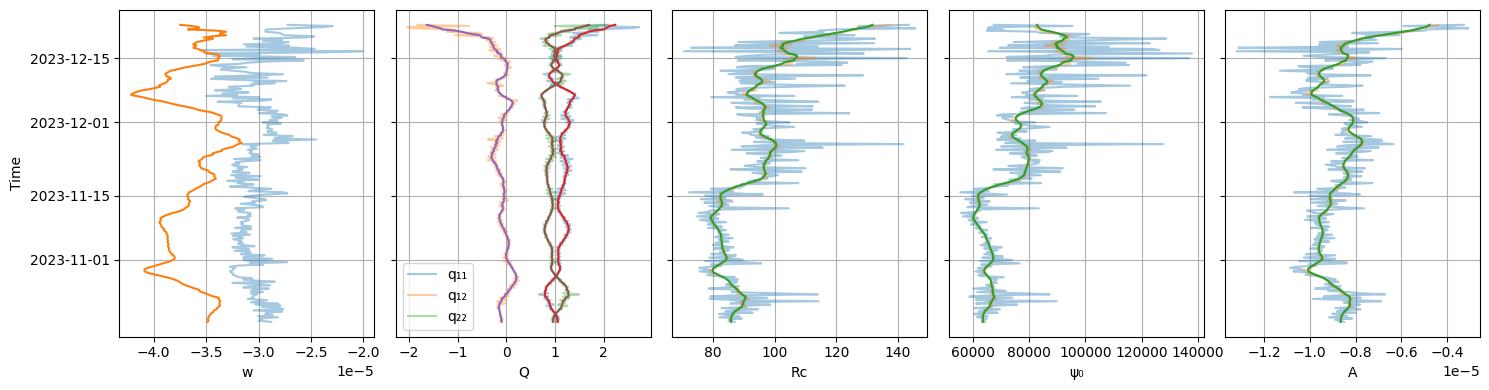

In [9]:
wdw = 6
# df_res['sw'] = smooth(df_res.w, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc_opt, df_res.Time, window=wdw, num=len(df_res)) 
# df_res['spsi0'] = smooth(df_res.psi0_opt, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A_opt, df_res.Time, window=wdw, num=len(df_res)) 

# Optimal 
df_res['sw'] = 2*df_res.sA*(df_res.sq11 + df_res.sq22)
df_res['spsi0'] = -df_res.sA*df_res.sRc**2

fig, axs = plt.subplots(1, 5, figsize=(15,4), sharey=True)
alpha = .4

axs[0].plot(df_res.w, df_res.Time, alpha=alpha)
axs[0].plot(df_res.sw, df_res.Time)
axs[0].set_xlabel('w')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, label='q₁₁', alpha=alpha)
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, label='q₁₂', alpha=alpha)
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, label='q₂₂', alpha=alpha)
axs[1].plot(df_res.sq11, df_res.Time)
axs[1].plot(df_res.sq12, df_res.Time)
axs[1].plot(df_res.sq22, df_res.Time)
axs[1].set_xlabel('Q')
axs[1].legend()

axs[2].plot(df_res.Rc/1000, df_res.Time, alpha=alpha)
axs[2].plot(df_res.Rc_opt/1000, df_res.Time, alpha=alpha)
axs[2].plot(df_res.sRc/1000, df_res.Time)
axs[2].set_xlabel('Rc')

axs[3].plot(df_res.psi0, df_res.Time, alpha=alpha)
axs[3].plot(df_res.psi0_opt, df_res.Time, alpha=alpha)
axs[3].plot(df_res.spsi0, df_res.Time)
axs[3].set_xlabel('ψ₀')

axs[4].plot(df_res.A, df_res.Time, alpha=alpha)
axs[4].plot(df_res.A_opt, df_res.Time, alpha=alpha)
axs[4].plot(df_res.sA, df_res.Time)
axs[4].set_xlabel('A')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Time')

plt.tight_layout()


In [10]:
X, Y = x_ssh, y_ssh

U = np.zeros((X.shape[0], X.shape[1], len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(df_res)))

for k in range(len(df_res)):
    data = df_res.iloc[k]
    dx, dy = X - data.sxc, Y - data.syc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

    U[:,:,k] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 


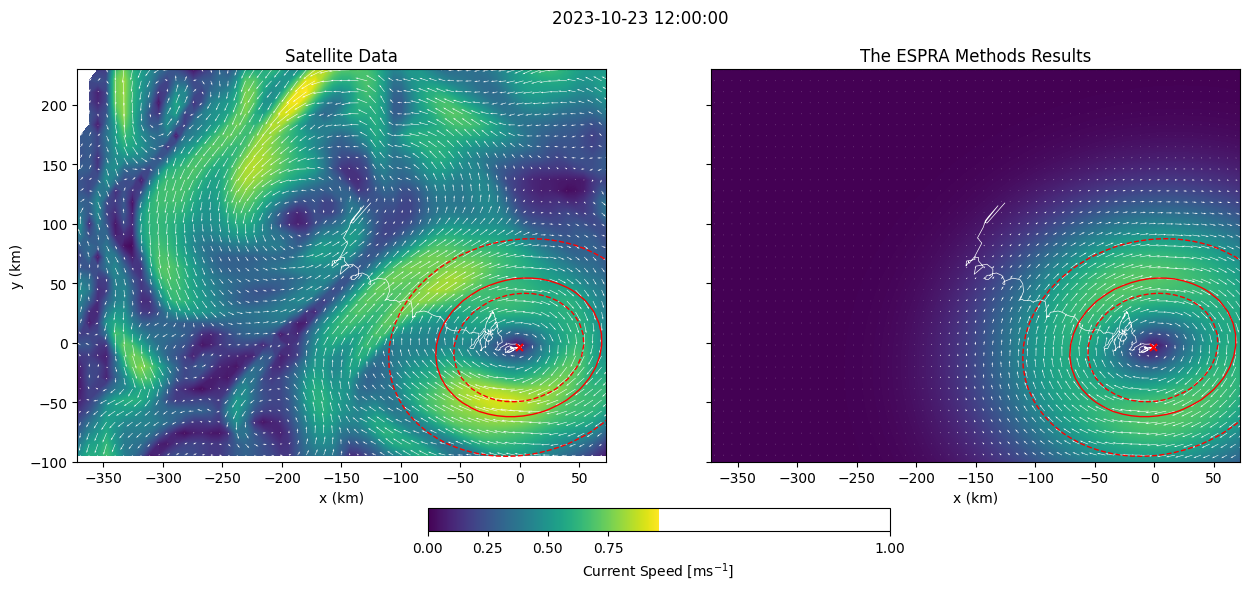

In [11]:
t_idx = 20
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

data = df_res.iloc[t_idx]

# data & masks
closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
spd1 = np.hypot(ut_mask, vt_mask)

u, v = U[:,:,t_idx], V[:,:,t_idx]
spd2 = np.hypot(u, v)

# shared colour scale: force 0 baseline, use combined max, and FIX levels
vmin = 0.0
vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
cmap = 'viridis'
levels = np.linspace(vmin, vmax, 256)  # identical bins for both
norm = plt.Normalize(vmin, vmax)

# --- plot 1 ---
cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
axs[0].quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=.001, scale=30, color='w')
axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')

# --- plot 2 ---
cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
spac = 1
axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
              u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The ESPRA Methods Results')
axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)

# shared colourbar reflects exactly those shared levels
cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label(r'Current Speed [ms$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, round(vmax, 1), 5))
# plt.tight_layout()
fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
plt.show()


In [12]:
# # MOVIE
# for t_idx in range(len(df_res)):
#     fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
#     data = df_res.iloc[t_idx]
    
#     # data & masks
#     closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
#     ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
#     mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
#     ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
#     spd1 = np.hypot(ut_mask, vt_mask)
    
#     u, v = U[:,:,t_idx], V[:,:,t_idx]
#     spd2 = np.hypot(u, v)
    
#     # shared colour scale: force 0 baseline, use combined max, and FIX levels
#     vmin = 0.0
#     # vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
#     vmax = 1
#     cmap = 'viridis'
#     levels = np.linspace(vmin, vmax, 256)  # identical bins for both
#     norm = plt.Normalize(vmin, vmax)
    
#     # --- plot 1 ---
#     cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
#     axs[0].quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=.001, scale=30, color='w')
#     axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
#     dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
#     rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
#     axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
#     axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')
    
#     # --- plot 2 ---
#     cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
#     spac = 1
#     axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
#                   u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
#     axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
#     axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The ESPRA Methods Results')
#     axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)
    
#     # shared colourbar reflects exactly those shared levels
#     cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
#     cbar.set_label(r'Current Speed [ms$^{-1}$]')
#     cbar.set_ticks(np.linspace(vmin, 1, 5))

#     fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
#     plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/ESPRA_IMOS_Data/tracking_images/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
#     plt.close()



In [13]:
df_res['Data'] = 'Satellite'
df_res['Method'] = 'ESPRA'
df_res


xc             yc         w  \
0     -8889.976330   -4256.986103 -0.000029   
1     -4698.739050   -4114.006644 -0.000030   
2     -8152.464261   -1965.855501 -0.000030   
3     -7279.129178   -9218.100343 -0.000030   
4     -4685.717073    -484.474034 -0.000028   
..             ...            ...       ...   
255 -133220.435252  110550.579627 -0.000029   
256 -119522.155987  130745.215727 -0.000027   
257 -170284.177903   66878.301452 -0.000024   
258 -135372.663749  106451.140746 -0.000023   
259 -115543.583771  128489.280666 -0.000027   

                                                     Q             Rc  \
0    [[1.0242373036542909, -0.09542101991089416], [...   86950.397808   
1    [[1.0680272993760624, -0.12809136281106048], [...   84958.630633   
2    [[1.0837587585112434, -0.06861732002365956], [...   85218.492452   
3    [[1.0089063372502542, -0.09125309048248038], [...   89310.377969   
4    [[1.0848451119938265, -0.13601125282480062], [...   81967.505845   
..                                                 ...            ...   
255  [[1.6892672840214467, -1.0936877835010999], [-...  120376.947490   
256  [[2.516061690955229, -1.9155967259627291], [-1...  145779.797925   
257  [[2.7258403567423577, -2.028534412953861], [-2...  130887.500359   
258  [[1.596527905285453, -0.7605457042064072], [-0...  127092.144066   
259  [[2.102783043663754, -1.8240197404025482], [-1...  143598.692395   

             psi0         A                Time         Rc_opt      psi0_opt  \
0    64311.156966 -0.000009 2023-10-18 12:00:00   86003.982523  63913.394494   
1    63381.322501 -0.000009 2023-10-18 18:00:00   85817.166971  63648.008597   
2    64581.771506 -0.000009 2023-10-19 00:00:00   85320.362221  63237.539854   
3    64985.227679 -0.000008 2023-10-19 06:00:00   86034.798238  63747.692309   
4    61547.515771 -0.000009 2023-10-19 12:00:00   85810.278476  63573.128685   
..            ...       ...                 ...            ...           ...   
255  71012.038062 -0.000005 2023-12-21 06:00:00  126781.102158  83890.055599   
256  65383.802092 -0.000003 2023-12-21 11:56:15  126612.159599  82244.430312   
257  65918.416129 -0.000004 2023-12-21 18:00:00  129217.570036  81963.446270   
258  95521.057786 -0.000006 2023-12-22 00:00:00  133831.850449  82892.523371   
259  67500.443018 -0.000003 2023-12-22 06:00:00  137517.945636  83235.888156   

     ...            syc      sq11      sq12      sq22            sRc  \
0    ...   -4185.496374  1.058674 -0.097377  0.954651   85713.837238   
1    ...   -3445.616083  1.046232 -0.095846  0.965845   85794.077488   
2    ...   -5099.320830  1.053955 -0.103879  0.960444   85797.317686   
3    ...   -3889.476626  1.051580 -0.104966  0.962626   85807.035378   
4    ...   -5055.460969  1.042517 -0.109187  0.972777   85885.417620   
..   ...            ...       ...       ...       ...            ...   
255  ...  115205.954834  2.002683 -1.312294  1.410247  125244.277924   
256  ...  102637.524272  2.040974 -1.341710  1.411450  127280.696929   
257  ...  101138.745376  2.076631 -1.441951  1.534180  129829.867295   
258  ...  100606.240955  2.126529 -1.524710  1.615812  130797.497556   
259  ...  117470.210706  2.235844 -1.632465  1.694749  131801.596405   

           sA        sw         spsi0       Data  Method  
0   -0.000009 -0.000035  63599.954803  Satellite   ESPRA  
1   -0.000009 -0.000035  63637.182234  Satellite   ESPRA  
2   -0.000009 -0.000035  63624.376483  Satellite   ESPRA  
3   -0.000009 -0.000035  63628.269918  Satellite   ESPRA  
4   -0.000009 -0.000035  63649.953707  Satellite   ESPRA  
..        ...       ...           ...        ...     ...  
255 -0.000005 -0.000037  84414.601763  Satellite   ESPRA  
256 -0.000005 -0.000036  83762.360391  Satellite   ESPRA  
257 -0.000005 -0.000036  83321.869473  Satellite   ESPRA  
258 -0.000005 -0.000036  83095.537541  Satellite   ESPRA  
259 -0.000005 -0.000037  82803.888640  Satellite   ESPRA  

[260 rows x 22 columns]

In [14]:
df_res.to_pickle("/srv/scratch/z5297792/ESP_Paper_Data/df_res_satellite_ESPRA.pkl")
